# step 1: Evaluate a data
https://github.com/googlecreativelab/quickdraw-dataset

we see that this dataset is a collection of 50 million drawing across 365 categories contributed by players from the game quick draw by google. Drawings were captured as timestamped vector, tagged with metadata(what players were supposed to draw)


The raw data is in ndjson format

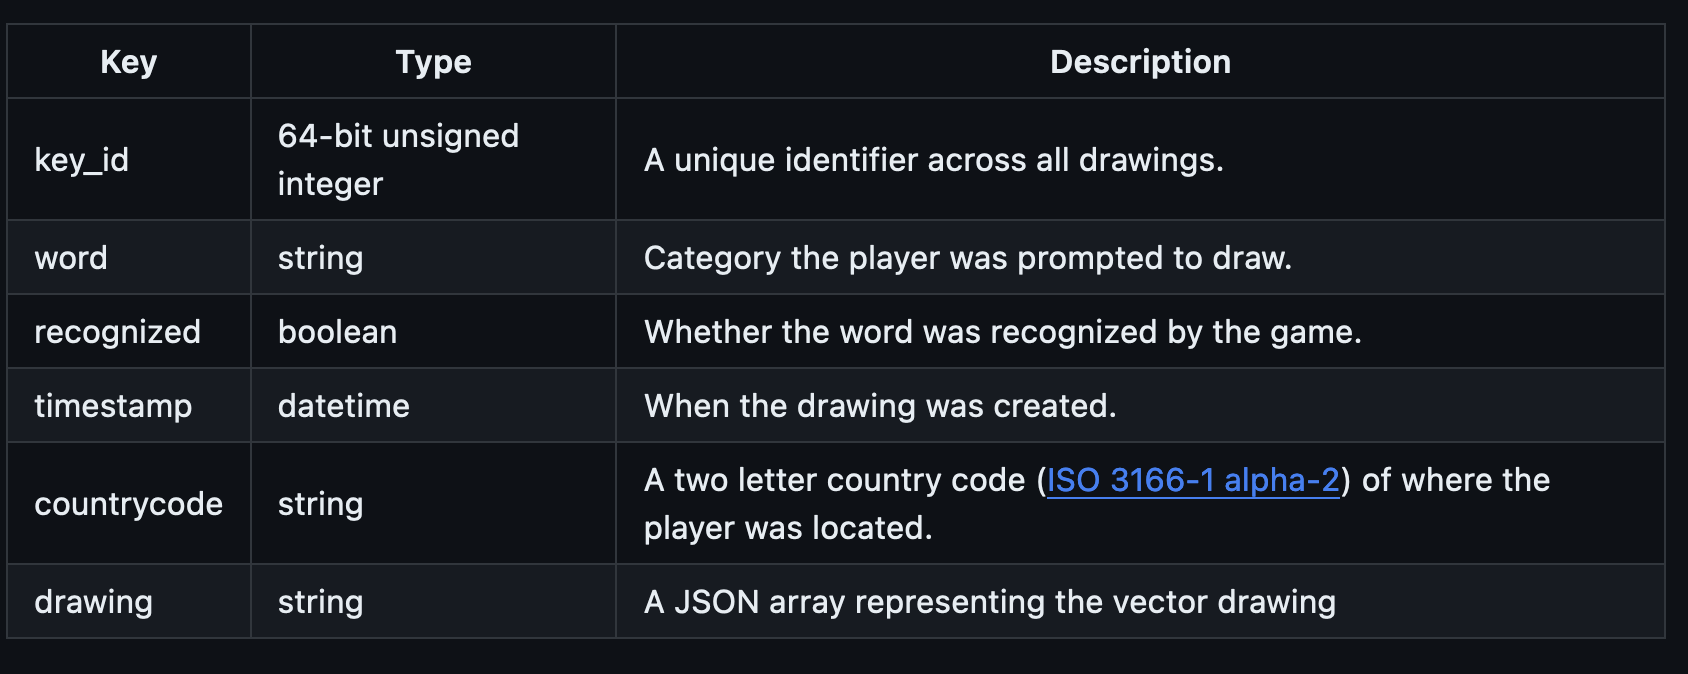




for example one drawing might be like this
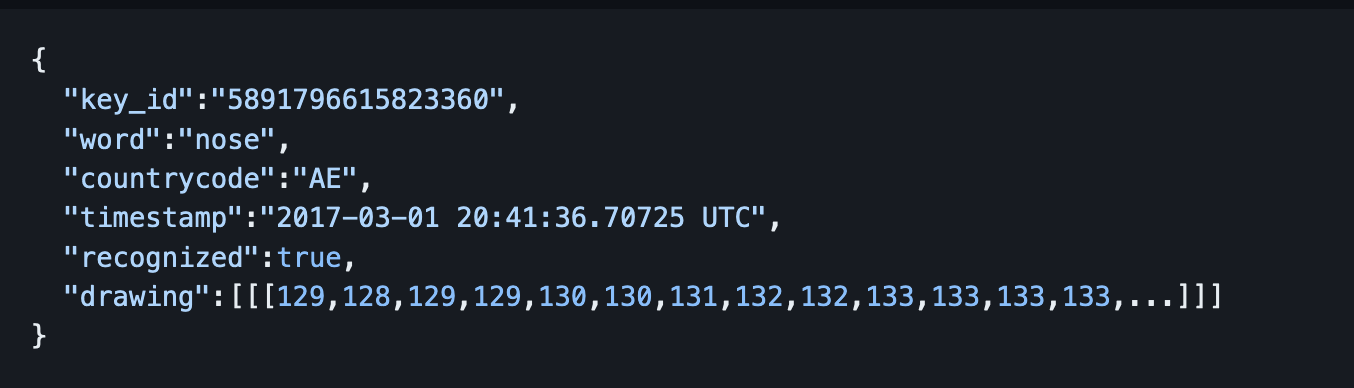

#and the format of one drawing array looks like this

 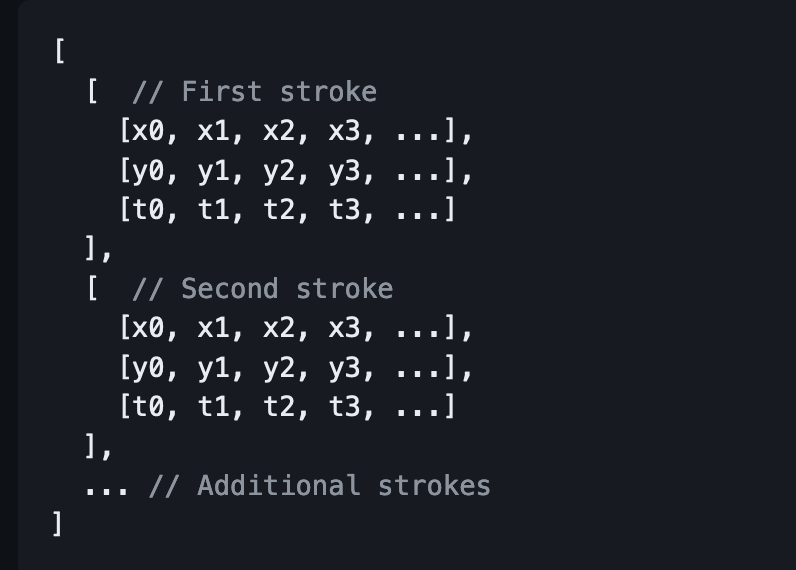

#Step 2: deciding class, creating a class.txt in google drive

inside the class.txt is 4 classes
check https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/raw;tab=objects?prefix=&forceOnObjectsSortingFiltering=false to see all classes


for example, i chose: house, eye, star, cup

In [ ]:
pwd

'/content'

In [36]:
#reading the classes

f = open("class.txt", "r")

classes = f.readlines()
f.close()

In [37]:
print(classes)

['house\n', 'cup\n', 'eye\n', 'star']


In [38]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [39]:
print(classes)

['house', 'cup', 'eye', 'star']


#we download the dataset, before doing so, we create a directory


In [ ]:
#creating a directory to store the dataset
!mkdir data

# Before downloading it, we have to explore the data

according to https://github.com/googlecreativelab/quickdraw-dataset

the raw moderated dataset is in ndjson format
and they provide us with preprocessed dataset on google cloud storage

### we have 4 different types of format
    Raw files (.ndjson)
    Simplified drawings files (.ndjson)
    Binary files (.bin)
    Numpy bitmap files (.npy)
##### we choose to use tensorflow and keras because we can work with numpy bitmap files directly

In [40]:
import urllib.request
def download():

  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [41]:
download()

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/house.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cup.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/eye.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/star.npy


In [43]:
#importing stuffs

import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

# Load the data

each class contains a different number of drawings stored as npy(humpy bitmap) format. we should load 5000 images for each class

In [44]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    #get the list of npy files in the path directory
    all_files = glob.glob(os.path.join(root, '*.npy'))
    #initialize variables
    # the drawings are simplied into 28x28 GRAYSCALE bitmap in numpy, aligned center
    # so we need to create an array that goes from 0 to 784(because 28x28 = 784)

    #initiate variables for input features(x) and labels(y)
    x = np.empty([0, 784]) #store a flatted 28x28 grayscale image
    y = np.empty([0]) #store corresponded labels

    #creating an array for 4 of our classes
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):

        #just load the data using np.load()
        data = np.load(file)

        #here we limit the number of maximum items for class to the defined parameter(which is 5000)
        data = data[0: max_items_per_class, :]

        #create labels for the loaded data(assigning a unique index for each class)
        labels = np.full(data.shape[0], idx)
        #concatenate existing image and labels into x and y

        x = np.concatenate((x, data), axis=0) #Concatenate data along rows
        y = np.append(y, labels) #keep appending labels to y array
        #extract class name and extension from the path name then add it to the list
        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing based on vfold ratio
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [45]:
#split into train
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [46]:
print(len(x_train))

12800


We show some data that were loaded

cup


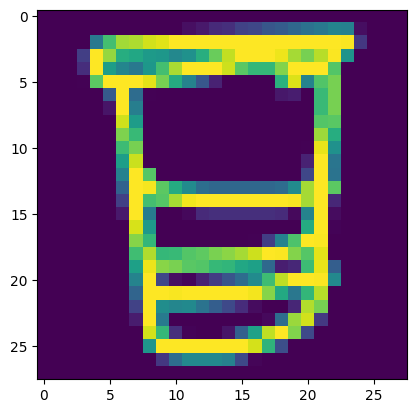

In [47]:
import matplotlib.pyplot as plt
from random import randint

%matplotlib inline

idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

###We see the data is loaded perfectly, now its time to

# Preprocess data`

In [48]:
#reshape and normalise
#remember we defined image_size = 28
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

# normalise the image to be in the range of [0, 1]
# why we need to normalise?

#giải thích bên facebook
# because normalising pixels to a consistent scale(which is from 0 to 1) ensures numerical stability
# during computing. Machine learning algorithms, and especially deep learning networks
# often use math operations like adding and multiplying, and working with big number
# can lead to large and complex values, making it difficult for model to learn effectively

# also it might be compatible with certain activation function, for example: sigmoid

# it can help with faster convergence speed





x_train /= 255
x_test /= 255

# convert class labels into one-hot encoded vector
# for example, if there are 10 classes, a class label 3 would be converted to [0, 0, 0, 1, 0, 0, 0, 0, 0, 0].
# 'num_classes' represents the total number of classes in the classification problem.


y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Making model

In [49]:
#define model, just basic CNN
#create a sequential cnn model

model = keras.Sequential()



#adding layers
model.add(layers.Convolution2D(16, (3, 3),
                               padding='same',
                               input_shape=x_train.shape[1:], activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))


model.add(layers.Convolution2D(32, (3, 3),
                               padding='same', activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Convolution2D(64, (3, 3),
                               padding='same', activation='relu'))

model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())


model.add(layers.Dense(128, activation='tanh'))


# change 4 to the number of classes that you have for the sake of classfication
model.add(layers.Dense(4, activation='softmax'))


#train the model


adam = tf.keras.optimizers.Adam()


model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

print(model.summary())







Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 3, 3, 64)         

Epoch 1/5
45/45 - 0s - loss: 0.0917 - accuracy: 0.9712 - val_loss: 0.0864 - val_accuracy: 0.9695 - 338ms/epoch - 8ms/step
Epoch 2/5
45/45 - 0s - loss: 0.0846 - accuracy: 0.9729 - val_loss: 0.0842 - val_accuracy: 0.9695 - 262ms/epoch - 6ms/step
Epoch 3/5
45/45 - 0s - loss: 0.0774 - accuracy: 0.9748 - val_loss: 0.0814 - val_accuracy: 0.9758 - 232ms/epoch - 5ms/step
Epoch 4/5
45/45 - 0s - loss: 0.0609 - accuracy: 0.9815 - val_loss: 0.0823 - val_accuracy: 0.9703 - 227ms/epoch - 5ms/step
Epoch 5/5
45/45 - 0s - loss: 0.0538 - accuracy: 0.9842 - val_loss: 0.0707 - val_accuracy: 0.9773 - 239ms/epoch - 5ms/step


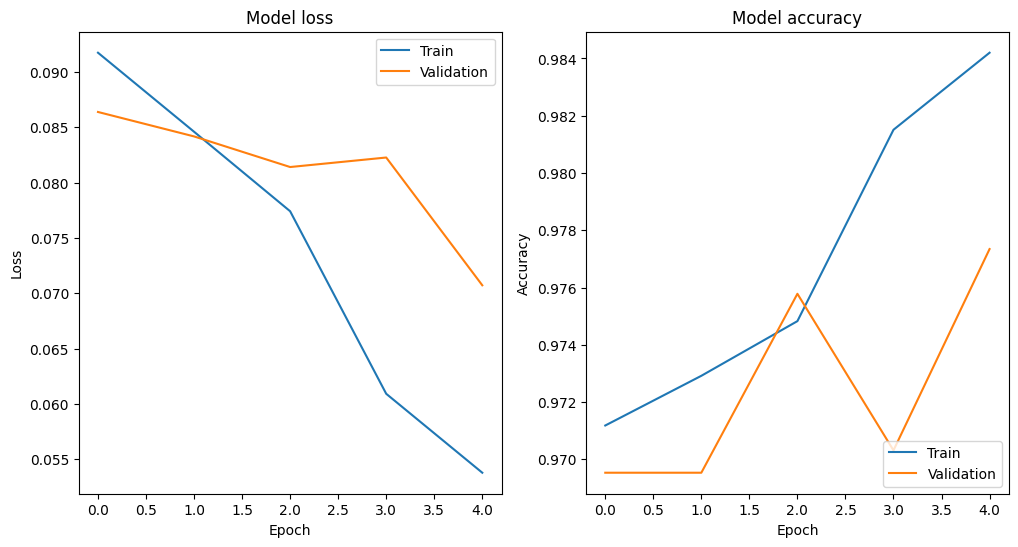

In [51]:
# Train the model and store the training history
history = model.fit(x=x_train, y=y_train, validation_split=0.1, batch_size=256, verbose=2, epochs=5)

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.show()

In [ ]:
#testing

In [52]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 96.16%


1/1 [==============================] - 0s 183ms/step
['star', 'cup', 'eye', 'house']


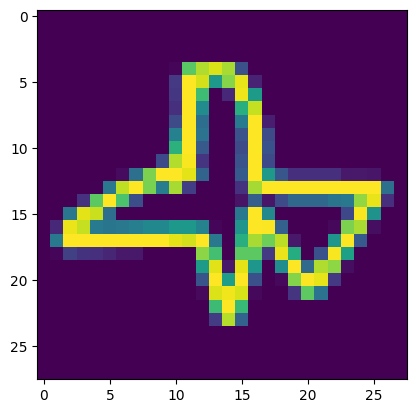

In [53]:
## Inference

import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

In [54]:
#storing classes
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

In [55]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 91.1 MB/s eta 0:00:00


In [56]:
#saving the model and download it into laptop
model.save('keras.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

2023-11-07 05:35:35.998056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 05:35:35.998115: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 05:35:35.998154: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 05:35:36.984530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [58]:
#zip and download
!cp class_names.txt model/class_names.txt

In [59]:
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/model.json (deflated 82%)
  adding: model/class_names.txt (stored 0%)
  adding: model/group1-shard1of1.bin (deflated 8%)


In [60]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>